# Neural Networks (2 Hidden Layers)

/Users/bran/Desktop/Uni Documents/Year 4/Sem 2/DSE4101/empirical_stock_pricing/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/100
659/659 - 1s - 1ms/step - loss: 0.0360 - val_loss: 0.0036
Epoch 2/100
659/659 - 0s - 673us/step - loss: 0.0058 - val_loss: 0.0015
Epoch 3/100
659/659 - 0s - 702us/step - loss: 0.0027 - val_loss: 9.4291e-04
Epoch 4/100
659/659 - 0s - 715us/step - loss: 0.0018 - val_loss: 7.4515e-04
Epoch 5/100
659/659 - 0s - 745us/step - loss: 0.0014 - val_loss: 6.7433e-04
Epoch 6/100
659/659 - 1s - 764us/step - loss: 0.0012 - val_loss: 6.5071e-04
Epoch 7/100
659/659 - 0s - 685us/step - loss: 0.0011 - val_loss: 6.8494e-04
Epoch 8/100
659/659 - 0s - 715us/step - loss: 0.0011 - val_loss: 6.3572e-04
Epoch 9/100
659/659 - 0s - 720us/step - loss: 0.0010 - val_loss: 6.0993e-04
Epoch 10/100
659/659 - 0s - 751us/step - loss: 0.0010 - val_loss: 5.9055e-04
Epoch 11/100
659/659 - 1s - 761us/step - loss: 9.8206e-04 - val_loss: 5.9282e-04
Epoch 12/100
659/659 - 0s - 671us/step - loss: 9.4490e-04 - val_loss: 5.8931e-04
Epoch 13/100
659/659 - 0s - 756us/step - loss: 9.3306e-04 - val_loss: 5.8057e-04
Epoch 

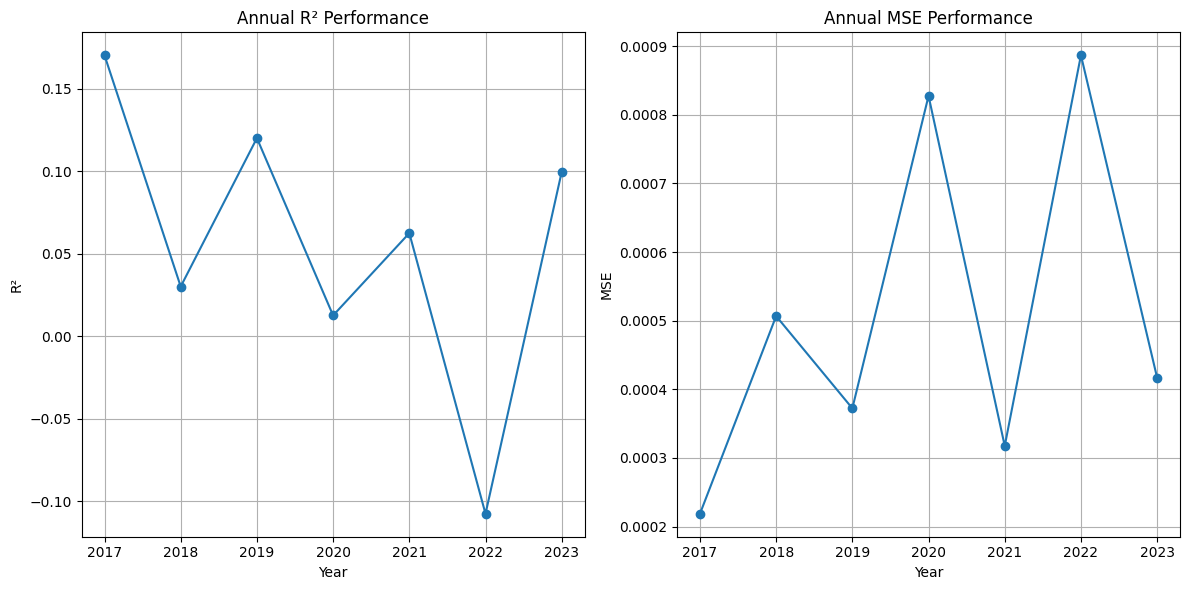

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import random

# Set seed for reproducibility
SEED = 4101
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

initial_train_start = 1990
prediction_years = list(range(2017, 2024))
features = [
    'mom1m', 'mom12m', 'mom36m', 'chmom', 'maxret', 'mvel1', 'dolvol', 'ill',
    'zerotrade', 'baspread', 'beta', 'idiovol', 'betasq', 'CAPEI', 'bm', 'evm',
    'pe_op_basic', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'npm', 'opmbd', 'opmad',
    'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'aftret_eq', 'aftret_invcapx',
    'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap',
    'totdebt_invcap', 'capital_ratio', 'cash_lt', 'invt_act', 'rect_act',
    'debt_at', 'debt_ebitda', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
    'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital',
    'de_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'rect_turn',
    'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'ptb', 'TBL', 'TMS', 'DFY'
]
target = "risk_premium"

# Model builder function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(features),)),
        tf.keras.layers.Dense(
            units=hp.Int('hidden_units_1', min_value=64, max_value=256, step=64),
            activation='relu'
        ),
        tf.keras.layers.Dropout(
            rate=hp.Float('dropout_rate_1', min_value=0.2, max_value=0.5, step=0.1)
        ),
        tf.keras.layers.Dense(
            units=hp.Int('hidden_units_2', min_value=32, max_value=128, step=32),
            activation='relu'
        ),
        tf.keras.layers.Dense(1)  # Output layer for regression
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
        ),
        loss='mse'
    )
    return model

# Load and preprocess data
df = pd.read_csv('../data/weekly_df.csv')
df = df[df['mvel1'] != -np.inf]
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Validate dataset columns
required_columns = features + [target, "Date"]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Missing columns in the dataset: {missing_columns}")

# Remove rows with infinite values and drop NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

metrics = []
best_hyperparams = {}

# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='stock_risk_premium'
)

for prediction_year in prediction_years:
    train_start = initial_train_start
    train_end = prediction_year - 2
    val_year = prediction_year - 1
    
    # Split data into training, validation, and testing sets
    train_mask = (df['Date'].dt.year >= train_start) & (df['Date'].dt.year <= train_end)
    val_mask = df['Date'].dt.year == val_year
    test_mask = df['Date'].dt.year == prediction_year
    
    if sum(train_mask) == 0 or sum(val_mask) == 0 or sum(test_mask) == 0:
        print(f"Skipping {prediction_year} due to insufficient data.")
        continue
    
    # Scale features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(df.loc[train_mask, features])
    X_val = scaler.transform(df.loc[val_mask, features])
    X_test = scaler.transform(df.loc[test_mask, features])
    y_train = df.loc[train_mask, target].values
    y_val = df.loc[val_mask, target].values
    y_test = df.loc[test_mask, target].values
    
    # Hyperparameter tuning for years <= 2018
    if prediction_year <= 2018:
        tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
        best_hyperparams[prediction_year] = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # Build and train the final model using best hyperparameters
    hp_params = best_hyperparams.get(prediction_year) or tuner.get_best_hyperparameters(num_trials=1)[0]
    
    final_model = build_model(hp_params)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    
    final_model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=2
    )
    
    # Make predictions on the test set and calculate metrics
    y_pred = final_model.predict(X_test).flatten()
    
    metrics.append({
        "Year": prediction_year,
        "R2": r2_score(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "N_Weeks": len(y_test)
    })

# Save metrics to CSV file and visualize results
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("r2_scores_NN2.csv", index=False)

plt.figure(figsize=(12, 6))

# Plot R² scores over years
plt.subplot(1, 2, 1)
plt.plot(metrics_df['Year'], metrics_df['R2'], marker='o')
plt.title("Annual R² Performance")
plt.xlabel("Year")
plt.ylabel("R²")
plt.grid(True)

# Plot MSE over years
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Year'], metrics_df['MSE'], marker='o')
plt.title("Annual MSE Performance")
plt.xlabel("Year")
plt.ylabel("MSE")
plt.grid(True)

plt.tight_layout()
plt.savefig("performance_metrics1.png", dpi=300)
plt.show()

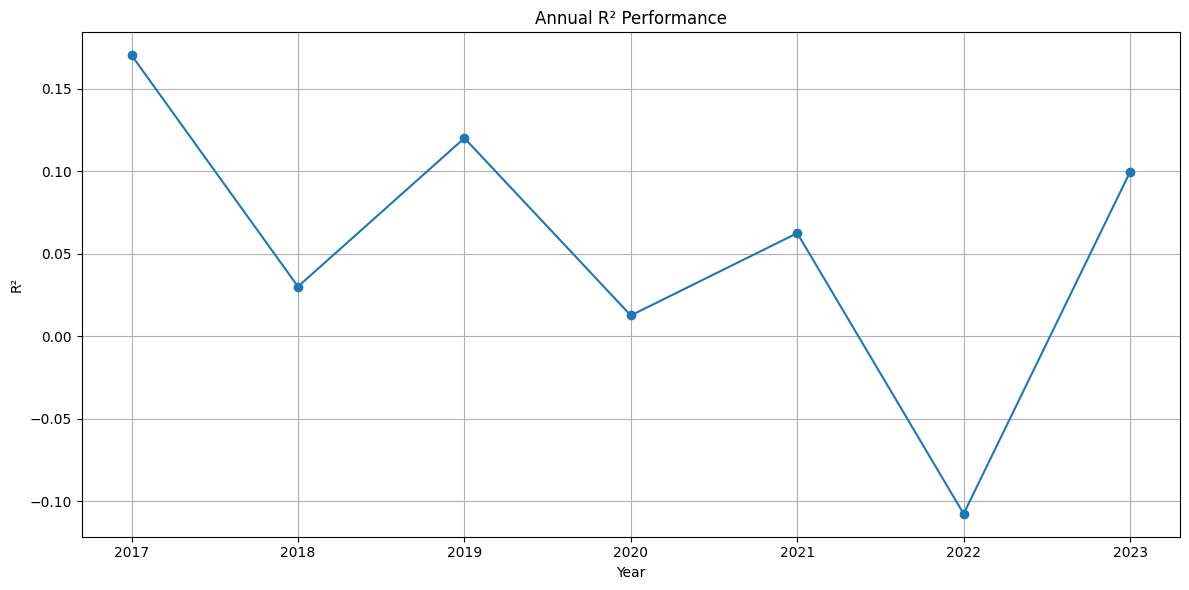

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
metrics_df = pd.read_csv("r2_scores_NN2.csv")

plt.figure(figsize=(12, 6))

# Plot R² scores over years
plt.plot(metrics_df['Year'], metrics_df['R2'], marker='o')
plt.title("Annual R² Performance")
plt.xlabel("Year")
plt.ylabel("R²")
plt.grid(True)

plt.tight_layout()
plt.savefig("performance_metrics1.png", dpi=300)
plt.show()

# Neural Networks (3 hidden layers)

Reloading Tuner from keras_tuner_dir2/stock_risk_premium/tuner0.json
Epoch 1/100
659/659 - 1s - 2ms/step - loss: 0.0203 - val_loss: 0.0014
Epoch 2/100
659/659 - 1s - 846us/step - loss: 0.0022 - val_loss: 6.4964e-04
Epoch 3/100
659/659 - 1s - 849us/step - loss: 0.0013 - val_loss: 6.3674e-04
Epoch 4/100
659/659 - 1s - 877us/step - loss: 0.0011 - val_loss: 6.3282e-04
Epoch 5/100
659/659 - 1s - 869us/step - loss: 0.0011 - val_loss: 6.2831e-04
Epoch 6/100
659/659 - 1s - 904us/step - loss: 0.0010 - val_loss: 6.3082e-04
Epoch 7/100
659/659 - 1s - 892us/step - loss: 0.0010 - val_loss: 6.2334e-04
Epoch 8/100
659/659 - 1s - 897us/step - loss: 9.9266e-04 - val_loss: 6.3309e-04
Epoch 9/100
659/659 - 1s - 915us/step - loss: 9.7571e-04 - val_loss: 6.0606e-04
Epoch 10/100
659/659 - 1s - 848us/step - loss: 9.6859e-04 - val_loss: 6.1542e-04
Epoch 11/100
659/659 - 1s - 846us/step - loss: 9.5229e-04 - val_loss: 6.0267e-04
Epoch 12/100
659/659 - 1s - 981us/step - loss: 9.3753e-04 - val_loss: 5.7635e-04
Ep

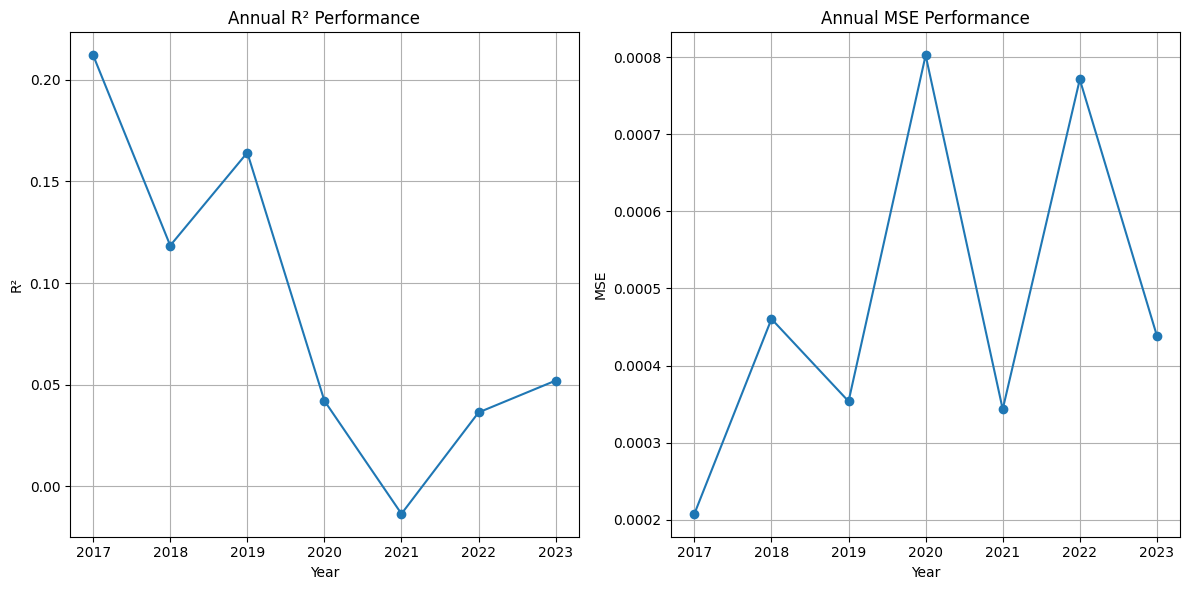

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import random

# Set seed for reproducibility
SEED = 4101
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Configuration
initial_train_start = 1990
prediction_years = list(range(2017, 2024))
features = [
    'mom1m', 'mom12m', 'mom36m', 'chmom', 'maxret', 'mvel1', 'dolvol', 'ill',
    'zerotrade', 'baspread', 'beta', 'idiovol', 'betasq', 'CAPEI', 'bm', 'evm',
    'pe_op_basic', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'npm', 'opmbd', 'opmad',
    'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'aftret_eq', 'aftret_invcapx',
    'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap',
    'totdebt_invcap', 'capital_ratio', 'cash_lt', 'invt_act', 'rect_act',
    'debt_at', 'debt_ebitda', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
    'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital',
    'de_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'rect_turn',
    'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'ptb', 'TBL', 'TMS', 'DFY'
]
target = "risk_premium"

# Model builder function

def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(features),)),
        tf.keras.layers.Dense(
            units=hp.Int('hidden_units_1', min_value=64, max_value=512, step=64),
            activation='relu'
        ),
        tf.keras.layers.Dropout(rate=hp.Float('dropout_rate_1', min_value=0.2, max_value=0.5, step=0.1)),

        tf.keras.layers.Dense(
            units=hp.Int('hidden_units_2', min_value=32, max_value=256, step=32),
            activation='relu'  
        ),
        
        tf.keras.layers.Dropout(rate=hp.Float('dropout_rate_1', min_value=0.2, max_value=0.5, step=0.1)),
        
        tf.keras.layers.Dense(
            units=hp.Int('hidden_units_3', min_value=16, max_value=128, step=16),
            activation='relu'  
        ),
        
        tf.keras.layers.Dense(1)  # Output layer for regression
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='mse'
    )
    return model

# Load and preprocess data
df = pd.read_csv('../data/weekly_df.csv')
df = df[df['mvel1'] != -np.inf]
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

metrics = []
best_hyperparams = {}
dm_test_results = []

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='keras_tuner_dir2',
    project_name='stock_risk_premium'
)

for prediction_year in prediction_years:
    train_start = initial_train_start
    train_end = prediction_year - 2
    val_year = prediction_year - 1

    train_mask = (df['Date'].dt.year >= train_start) & (df['Date'].dt.year <= train_end)
    val_mask = df['Date'].dt.year == val_year
    test_mask = df['Date'].dt.year == prediction_year

    if sum(train_mask) == 0 or sum(val_mask) == 0 or sum(test_mask) == 0:
        print(f"Skipping {prediction_year} due to insufficient data.")
        continue

    scaler = StandardScaler()
    X_train = scaler.fit_transform(df.loc[train_mask, features])
    X_val = scaler.transform(df.loc[val_mask, features])
    X_test = scaler.transform(df.loc[test_mask, features])
    y_train = df.loc[train_mask, target].values
    y_val = df.loc[val_mask, target].values
    y_test = df.loc[test_mask, target].values

    if prediction_year <= 2018:
        tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
        best_hyperparams[prediction_year] = tuner.get_best_hyperparameters(num_trials=1)[0]

    hp_params = best_hyperparams.get(prediction_year) or tuner.get_best_hyperparameters(num_trials=1)[0]

    final_model = build_model(hp_params)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    final_model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=2
    )

    y_pred = final_model.predict(X_test).flatten()

    metrics.append({
        "Year": prediction_year,
        "R2": r2_score(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "N_Weeks": len(y_test)
    })

    for actual, predicted in zip(y_test, y_pred):
        dm_test_results.append({
            "Year": prediction_year,
            "Actual": actual,
            "Predicted": predicted
        })

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("r2_scores_NN3.csv", index=False)

dm_test_df = pd.DataFrame(dm_test_results)
dm_test_df.to_csv("dm_test_results_NN.csv", index=False)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(metrics_df['Year'], metrics_df['R2'], marker='o')
plt.title("Annual R² Performance")
plt.xlabel("Year")
plt.ylabel("R²")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(metrics_df['Year'], metrics_df['MSE'], marker='o')
plt.title("Annual MSE Performance")
plt.xlabel("Year")
plt.ylabel("MSE")
plt.grid(True)

plt.tight_layout()
plt.savefig("performance_metrics2.png", dpi=300)
plt.show()


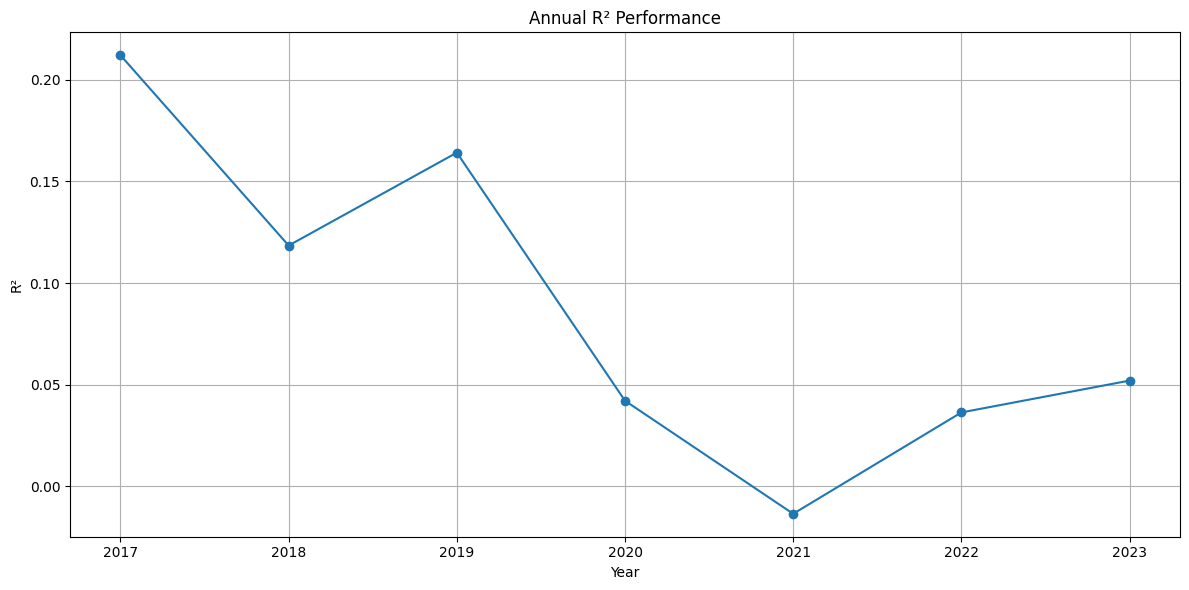

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
metrics_df = pd.read_csv("r2_scores_NN3.csv")

plt.figure(figsize=(12, 6))

# Plot R² scores over years
plt.plot(metrics_df['Year'], metrics_df['R2'], marker='o')
plt.title("Annual R² Performance")
plt.xlabel("Year")
plt.ylabel("R²")
plt.grid(True)

plt.tight_layout()
plt.savefig("performance_metrics2.png", dpi=300)
plt.show()

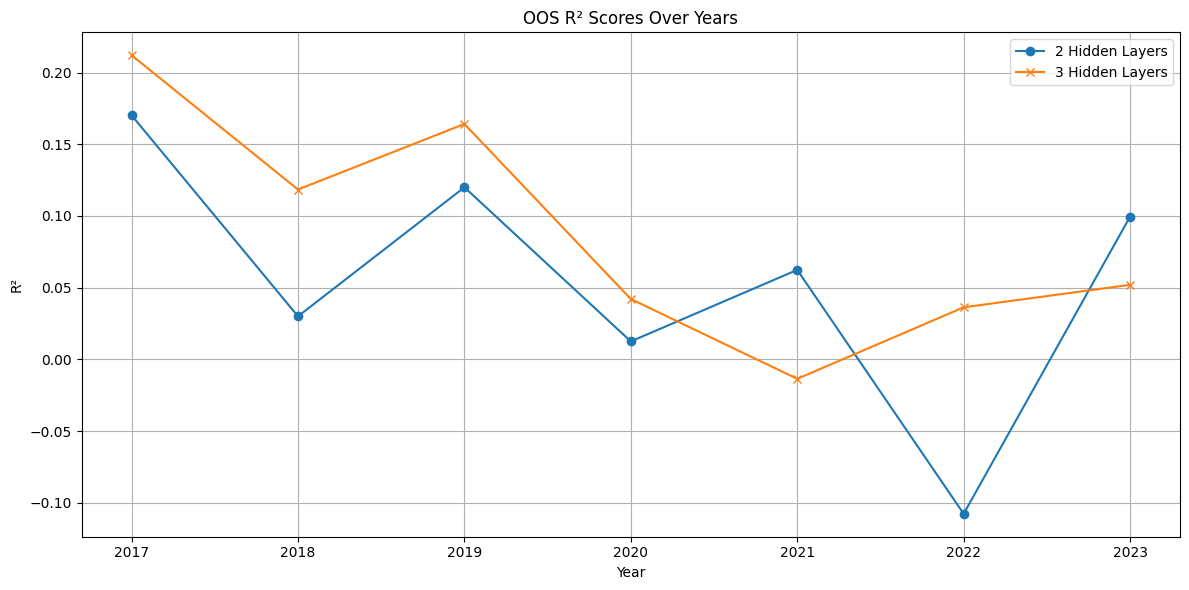

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and filter metrics data
metrics_df1 = pd.read_csv("NN1_performance_metrics.csv")
metrics_df1 = metrics_df1[metrics_df1['Year'] != 2016]

metrics_df2 = pd.read_csv("NN2_performance_metrics.csv")
metrics_df2 = metrics_df2[metrics_df2['Year'] != 2016]

plt.figure(figsize=(12, 6))

# Plot R² scores over years for both models
plt.plot(metrics_df1['Year'], metrics_df1['R2'], marker='o', label='2 Hidden Layers')
plt.plot(metrics_df2['Year'], metrics_df2['R2'], marker='x', label='3 Hidden Layers')

plt.title("OOS R² Scores Over Years")
plt.xlabel("Year")
plt.ylabel("R²")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("performance_metrics_comparison.png", dpi=300)
plt.show()
